# EXPT-12e: Gamma Sweep with Rigorous Symplectic Tracking (v2)--connecting with Lyapunov stability analysis proof originally in Appendix A and detailed analysis in Appendix-Q
## Characterizing Learning via Liouvillian Area/volume Preservation

### The "key-error" below is cosmetic in nature, and may be ignored, it does not affect results/analysis here, or in Appendix-Q

---

## 🎯 Hypothesis

**Deviations from symplecticity mark phase transitions in learning.**

---

## 📐 Symplectic Metrics (RIGOROUS)

### What We're Actually Measuring

The **full attention layer** map includes learned weights:
```
F: x → LayerNorm → c_attn → RoPE → Momentum → Attention → c_proj → x'
```

We compute TWO complementary metrics:

### 1. Subspace Jacobian (16×16)
```
J_ij = (F(x + ε·e_j) - F(x))_i / ε    for i,j ∈ [0, dim)
```
- **Caveat**: Subject to "subspace leakage" — energy flows to unmeasured dims
- **Interpretation**: Look for TRENDS and SPIKES, not absolute values
- **Cross-γ comparison valid**: Same leakage affects all γ

### 2. Energy Ratio (Leakage-Free) ⭐ NEW
```
R = ||F(x + ε·e_j) - F(x)||_full / ε
```
- Measures TOTAL output displacement across ALL 768 dimensions
- No subspace truncation → no leakage artifact
- R > 1: Expansion, R < 1: Contraction, R = 1: Isometry

---

## ⚠️ Interpretive Guidelines

| Observation | Valid Interpretation |
|-------------|---------------------|
| `det(J) < 1` consistently | Cannot conclude contraction (leakage) |
| `det(J)` spikes then recovers | **Phase transition signal** |
| `det(J)` differs by γ | Meaningful (same leakage for all) |
| `energy_ratio` deviates from 1 | True volume change (leakage-free) |

---



In [ ]:
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List, Any
import math
import time
import json
import gc
import warnings
import random
from datetime import datetime
from pathlib import Path

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 150, 'savefig.dpi': 300, 'font.size': 11,
    'font.family': 'serif', 'axes.labelsize': 12, 'axes.titlesize': 13,
    'axes.titleweight': 'bold', 'legend.fontsize': 10, 'figure.facecolor': 'white',
    'axes.grid': True, 'grid.alpha': 0.3, 'lines.linewidth': 2,
    'axes.spines.top': False, 'axes.spines.right': False
})

GAMMA_COLORS = {0.0: '#E63946', 0.2: '#F4A261', 0.4: '#E9C46A', 0.6: '#2A9D8F', 0.8: '#264653', 1.0: '#1D3557'}
MASTER_SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(MASTER_SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('=' * 70)
print('📐  EXPT-12e: GAMMA SWEEP + SYMPLECTIC TRACKING (v2)  📐')
print('=' * 70)
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
print(f'Started: {datetime.now()}')
print('=' * 70)

📐  EXPT-12e: GAMMA SWEEP + SYMPLECTIC TRACKING (v2)  📐
Device: cuda
GPU: NVIDIA GB10
Memory: 128.5 GB
Started: 2025-12-28 09:27:38.103262


In [ ]:
# =============================================================================
# CELL 2: CONFIGURATIONS
# =============================================================================
@dataclass
class GPTConfig:
    name: str = 'model'
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    vocab_size: int = 8192
    block_size: int = 512
    dropout: float = 0.1
    use_momentum: bool = True
    gamma: float = 0.0
    rope_theta: float = 10000.0

    @property
    def n_params(self) -> int:
        emb = self.vocab_size * self.n_embd + self.block_size * self.n_embd
        per_layer = 4 * self.n_embd**2 + 8 * self.n_embd**2 + 4 * self.n_embd
        head = self.n_embd * self.vocab_size
        return emb + self.n_layer * per_layer + head

@dataclass
class TrainConfig:
    block_size: int = 512
    batch_size: int = 64
    fluency_ratio: float = 0.9
    copy_prob: float = 0.3
    max_lookback: int = 10
    total_steps: int = 10000
    eval_interval: int = 250
    eval_steps: int = 50
    lr: float = 1e-3
    weight_decay: float = 0.1
    beta1: float = 0.9
    beta2: float = 0.95
    grad_clip: float = 1.0
    warmup_steps: int = 500
    # Symplectic tracking
    jacobian_samples: int = 4
    jacobian_seq_len: int = 32
    jacobian_dim: int = 16          # Subspace for tractable Jacobian
    jacobian_eps: float = 1e-4
    energy_perturbations: int = 8   # Number of random directions for energy ratio

GAMMA_VALUES = [0.0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.007, 0.009, 0.01, 0.05, 0.1, 0.15]
train_cfg = TrainConfig()

print(f'Gamma values: {GAMMA_VALUES}')
print(f'Learning rate: {train_cfg.lr}')
print(f'Jacobian: {train_cfg.jacobian_dim}D subspace, ε={train_cfg.jacobian_eps}')
print(f'Energy ratio: {train_cfg.energy_perturbations} random perturbations (leakage-free)')

Gamma values: [0.0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.007, 0.009, 0.01, 0.05, 0.1, 0.15]
Learning rate: 0.001
Jacobian: 16D subspace, ε=0.0001
Energy ratio: 8 random perturbations (leakage-free)


In [ ]:
# =============================================================================
# CELL 3: ROPE IMPLEMENTATION
# =============================================================================
class RotaryPositionEmbedding(nn.Module):
    def __init__(self, dim: int, theta: float = 10000.0, max_len: int = 2048):
        super().__init__()
        inv_freq = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self._cos_cache = None
        self._sin_cache = None
        self._cached_len = 0
        self.max_len = max_len

    def _update_cache(self, seq_len: int, device):
        if self._cos_cache is None or seq_len > self._cached_len:
            self._cached_len = max(seq_len, self.max_len)
            t = torch.arange(self._cached_len, device=device).float()
            freqs = torch.outer(t, self.inv_freq.to(device))
            self._cos_cache = freqs.cos().unsqueeze(0).unsqueeze(0)
            self._sin_cache = freqs.sin().unsqueeze(0).unsqueeze(0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, T, D = x.shape
        self._update_cache(T, x.device)
        cos = self._cos_cache[:, :, :T, :]
        sin = self._sin_cache[:, :, :T, :]
        x1, x2 = x[..., :D//2], x[..., D//2:]
        return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

print('✅ RoPE defined')

✅ RoPE defined


In [ ]:
# =============================================================================
# CELL 4: CAUSAL SELF-ATTENTION WITH MOMENTUM
# =============================================================================
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head
        self.use_momentum = config.use_momentum
        self.gamma = config.gamma

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)
        self.rope = RotaryPositionEmbedding(self.head_dim, theta=config.rope_theta)
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()

        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        q = self.rope(q)
        k = self.rope(k)

        if self.use_momentum and self.gamma > 0:
            q_prev = torch.roll(q, shifts=1, dims=2)
            q_prev[:, :, 0, :] = q[:, :, 0, :]
            k_prev = torch.roll(k, shifts=1, dims=2)
            k_prev[:, :, 0, :] = k[:, :, 0, :]
            p_q = q - q_prev
            p_k = k - k_prev
            q = q + self.gamma * p_q
            k = k + self.gamma * p_k

        scale = 1.0 / math.sqrt(self.head_dim)
        att = (q @ k.transpose(-2, -1)) * scale
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.c_proj(y)

print('✅ CausalSelfAttention defined')

✅ CausalSelfAttention defined


In [ ]:
# =============================================================================
# CELL 5: GPT MODEL
# =============================================================================
class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=False)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=False)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(F.gelu(self.c_fc(x), approximate='tanh')))

class TransformerBlock(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

    def forward_attn_only(self, x):
        """Forward through attention sublayer only (for Jacobian computation)."""
        return self.attn(self.ln_1(x))

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        print(f'{config.name}: {sum(p.numel() for p in self.parameters())/1e6:.1f}M params (γ={config.gamma})')

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        x = self.transformer.drop(self.transformer.wte(idx) + self.transformer.wpe(pos))
        for block in self.transformer.h:
            x = block(x)
        logits = self.lm_head(self.transformer.ln_f(x))
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) if targets is not None else None
        return logits, loss

print('✅ GPT model defined')

✅ GPT model defined


In [ ]:
# =============================================================================
# CELL 6: RIGOROUS SYMPLECTIC METRICS (WITH LEAKAGE-FREE ENERGY RATIO)
# =============================================================================
@torch.no_grad()
def compute_layer_jacobian(block: TransformerBlock, x: torch.Tensor,
                           dim: int, eps: float, pos_idx: int) -> torch.Tensor:
    """
    Compute the subspace Jacobian of attention sublayer via finite differences.

    CAVEAT: This is a dim×dim subblock of the full n_embd×n_embd Jacobian.
    Subject to "subspace leakage" — interpret TRENDS, not absolute values.
    """
    B, T, C = x.shape

    y_base = block.forward_attn_only(x)
    y_base_pos = y_base[0, pos_idx, :dim].clone()

    J = torch.zeros(dim, dim, device=x.device)

    for j in range(dim):
        x_perturbed = x.clone()
        x_perturbed[0, pos_idx, j] += eps
        y_perturbed = block.forward_attn_only(x_perturbed)
        y_perturbed_pos = y_perturbed[0, pos_idx, :dim]
        J[:, j] = (y_perturbed_pos - y_base_pos) / eps

    return J


@torch.no_grad()
def compute_energy_ratio(block: TransformerBlock, x: torch.Tensor,
                         eps: float, pos_idx: int, n_perturbations: int) -> Dict[str, float]:
    """
    Compute LEAKAGE-FREE energy ratio by measuring FULL output displacement.

    For each random perturbation direction:
        R = ||F(x + ε·v) - F(x)||_full / (ε * ||v||)

    This captures energy flow to ALL dimensions, not just a subspace.

    Returns:
        - energy_ratio_mean: Average expansion/contraction factor
        - energy_ratio_std: Variation across directions
        - energy_ratio_max: Maximum directional expansion
        - energy_ratio_min: Minimum directional expansion (max contraction)
    """
    B, T, C = x.shape

    y_base = block.forward_attn_only(x)
    y_base_pos = y_base[0, pos_idx, :].clone()  # FULL n_embd dimensions

    ratios = []

    for _ in range(n_perturbations):
        # Random unit perturbation direction in full n_embd space
        v = torch.randn(C, device=x.device)
        v = v / torch.norm(v)  # Unit vector

        # Perturb input
        x_perturbed = x.clone()
        x_perturbed[0, pos_idx, :] += eps * v

        # Measure FULL output displacement
        y_perturbed = block.forward_attn_only(x_perturbed)
        y_perturbed_pos = y_perturbed[0, pos_idx, :]

        # Energy ratio: output_displacement / input_displacement
        output_displacement = torch.norm(y_perturbed_pos - y_base_pos)
        input_displacement = eps  # ||eps * v|| = eps since ||v|| = 1

        ratio = (output_displacement / input_displacement).item()
        ratios.append(ratio)

    return {
        'energy_ratio_mean': np.mean(ratios),
        'energy_ratio_std': np.std(ratios),
        'energy_ratio_max': np.max(ratios),
        'energy_ratio_min': np.min(ratios)
    }


@torch.no_grad()
def compute_symplectic_metrics(model: GPT, config: TrainConfig) -> Dict[str, float]:
    """
    Compute comprehensive symplectic metrics:

    1. SUBSPACE JACOBIAN (dim×dim):
       - det(J): Volume change in subspace (CAVEAT: leakage)
       - κ(J): Condition number
       - ||J^T Ω J - Ω||: Symplectic deviation
       → Interpret TRENDS and CROSS-γ DIFFERENCES, not absolute values

    2. ENERGY RATIO (leakage-free): ⭐
       - R = ||ΔF||_full / ||Δx||: True volume proxy
       → R > 1: Expansion, R < 1: Contraction, R = 1: Isometry
    """
    model.eval()

    n_samples = config.jacobian_samples
    T = config.jacobian_seq_len
    dim = config.jacobian_dim
    eps = config.jacobian_eps
    n_energy = config.energy_perturbations

    # Storage
    all_det_residuals = []
    all_condition_numbers = []
    all_symplectic_norms = []
    all_energy_ratios = []
    all_energy_stds = []

    # Layers to probe: first, middle, last
    probe_layers = [0, model.config.n_layer // 2, model.config.n_layer - 1]

    for sample_idx in range(n_samples):
        # Random continuous input (bypass discrete tokens)
        x = torch.randn(1, T, model.config.n_embd, device=DEVICE) * 0.1
        pos_idx = T // 2  # Probe middle position

        for layer_idx in probe_layers:
            block = model.transformer.h[layer_idx]

            # === SUBSPACE JACOBIAN (with leakage caveat) ===
            J = compute_layer_jacobian(block, x, dim, eps, pos_idx)

            # Determinant residual
            try:
                det_J = torch.linalg.det(J)
                det_residual = torch.abs(det_J - 1.0).item()
            except:
                det_residual = float('nan')
            all_det_residuals.append(det_residual)

            # Condition number
            try:
                S = torch.linalg.svdvals(J)
                condition_number = (S.max() / (S.min() + 1e-10)).item()
            except:
                condition_number = float('nan')
            all_condition_numbers.append(condition_number)

            # Symplectic form deviation
            half_dim = dim // 2
            if half_dim > 0:
                Omega = torch.zeros(dim, dim, device=DEVICE)
                Omega[:half_dim, half_dim:] = torch.eye(half_dim, device=DEVICE)
                Omega[half_dim:, :half_dim] = -torch.eye(half_dim, device=DEVICE)
                symplectic_residual = J.T @ Omega @ J - Omega
                symplectic_norm = torch.norm(symplectic_residual, p='fro').item()
                all_symplectic_norms.append(symplectic_norm)

            # === ENERGY RATIO (leakage-free) ===
            energy_stats = compute_energy_ratio(block, x, eps, pos_idx, n_energy)
            all_energy_ratios.append(energy_stats['energy_ratio_mean'])
            all_energy_stds.append(energy_stats['energy_ratio_std'])

            # Propagate through block for next layer
            x = block(x)

    model.train()

    # Filter NaNs
    all_det_residuals = [x for x in all_det_residuals if not np.isnan(x)]
    all_condition_numbers = [x for x in all_condition_numbers if not np.isnan(x)]

    return {
        # Subspace Jacobian metrics (interpret trends, not absolute values)
        'det_residual': np.mean(all_det_residuals) if all_det_residuals else 0.0,
        'det_residual_std': np.std(all_det_residuals) if all_det_residuals else 0.0,
        'condition_number': np.mean(all_condition_numbers) if all_condition_numbers else 1.0,
        'condition_std': np.std(all_condition_numbers) if all_condition_numbers else 0.0,
        'symplectic_norm': np.mean(all_symplectic_norms) if all_symplectic_norms else 0.0,
        'symplectic_std': np.std(all_symplectic_norms) if all_symplectic_norms else 0.0,
        # Energy ratio (leakage-free, primary metric)
        'energy_ratio': np.mean(all_energy_ratios) if all_energy_ratios else 1.0,
        'energy_ratio_std': np.mean(all_energy_stds) if all_energy_stds else 0.0,
        'energy_ratio_spread': np.std(all_energy_ratios) if all_energy_ratios else 0.0,
    }

print('✅ Symplectic metrics with leakage-free energy ratio defined')
print('   - Subspace Jacobian: det(J), κ(J), ||J^TΩJ-Ω|| (interpret trends)')
print('   - Energy Ratio: ||ΔF||/||Δx|| over full n_embd (leakage-free) ⭐')

✅ Symplectic metrics with leakage-free energy ratio defined
   - Subspace Jacobian: det(J), κ(J), ||J^TΩJ-Ω|| (interpret trends)
   - Energy Ratio: ||ΔF||/||Δx|| over full n_embd (leakage-free) ⭐


In [ ]:
# =============================================================================
# CELL 7: DATA GENERATOR
# =============================================================================
class DualTaskDataset(IterableDataset):
    def __init__(self, config: TrainConfig, vocab_size: int = 8192):
        self.block_size = config.block_size
        self.fluency_ratio = config.fluency_ratio
        self.copy_prob = config.copy_prob
        self.max_lookback = config.max_lookback
        self.vocab_size = vocab_size
        self.tok_zero = vocab_size - 3
        self.tok_one = vocab_size - 2

    def generate_fluency_sample(self):
        data = torch.randint(0, self.vocab_size - 3, (self.block_size + 1,))
        for i in range(self.max_lookback, self.block_size + 1):
            if random.random() < self.copy_prob:
                data[i] = data[i - random.randint(1, self.max_lookback)]
        return data[:-1], data[1:], 'fluency'

    def generate_logic_sample(self):
        bits = torch.randint(0, 2, (self.block_size,))
        parity = torch.cumsum(bits, dim=0) % 2
        x = torch.where(bits == 0, self.tok_zero, self.tok_one)
        y = torch.where(parity == 0, self.tok_zero, self.tok_one)
        return x, y, 'logic'

    def __iter__(self):
        while True:
            yield self.generate_fluency_sample() if random.random() < self.fluency_ratio else self.generate_logic_sample()

print('✅ Data generator ready')

✅ Data generator ready


In [ ]:
# =============================================================================
# CELL 8: TRAINING FUNCTIONS
# =============================================================================
def get_lr(step: int, config: TrainConfig) -> float:
    if step < config.warmup_steps:
        return config.lr * step / config.warmup_steps
    progress = (step - config.warmup_steps) / (config.total_steps - config.warmup_steps)
    return config.lr * 0.5 * (1.0 + math.cos(math.pi * progress))

@torch.no_grad()
def evaluate(model, config):
    model.eval()
    dataset = DualTaskDataset(config, model.config.vocab_size)
    fluency_losses, logic_losses = [], []
    for _ in range(config.eval_steps):
        x, y, task = next(iter(dataset))
        x, y = x.unsqueeze(0).to(DEVICE), y.unsqueeze(0).to(DEVICE)
        _, loss = model(x, y)
        (fluency_losses if task == 'fluency' else logic_losses).append(loss.item())
    model.train()
    return {'fluency_loss': np.mean(fluency_losses) if fluency_losses else float('nan'),
            'logic_loss': np.mean(logic_losses) if logic_losses else float('nan')}

def train_model(model_config, train_config):
    print(f'\n{"="*70}\n📐 Training γ={model_config.gamma} with symplectic tracking (v2)\n{"="*70}')
    model = GPT(model_config).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.lr,
                                   betas=(train_config.beta1, train_config.beta2),
                                   weight_decay=train_config.weight_decay)
    dataset = DualTaskDataset(train_config, model_config.vocab_size)
    data_iter = iter(dataset)

    history = {
        'steps': [],
        'fluency_loss': [],
        'logic_loss': [],
        # Subspace metrics (interpret trends)
        'det_residual': [],
        'condition_number': [],
        'symplectic_norm': [],
        # Leakage-free metric (primary)
        'energy_ratio': [],
        'energy_ratio_std': []
    }

    model.train()
    start_time = time.time()

    for step in range(train_config.total_steps):
        batch_x, batch_y = [], []
        for _ in range(train_config.batch_size):
            x, y, _ = next(data_iter)
            batch_x.append(x)
            batch_y.append(y)
        x = torch.stack(batch_x).to(DEVICE)
        y = torch.stack(batch_y).to(DEVICE)

        lr = get_lr(step, train_config)
        for pg in optimizer.param_groups:
            pg['lr'] = lr

        _, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), train_config.grad_clip)
        optimizer.step()

        if step % train_config.eval_interval == 0 or step == train_config.total_steps - 1:
            ev = evaluate(model, train_config)
            symp = compute_symplectic_metrics(model, train_config)

            history['steps'].append(step)
            history['fluency_loss'].append(ev['fluency_loss'])
            history['logic_loss'].append(ev['logic_loss'])
            history['det_residual'].append(symp['det_residual'])
            history['condition_number'].append(symp['condition_number'])
            history['symplectic_norm'].append(symp['symplectic_norm'])
            history['energy_ratio'].append(symp['energy_ratio'])
            history['energy_ratio_std'].append(symp['energy_ratio_std'])

            print(f'  [{100*step/train_config.total_steps:5.1f}%] step={step:5d} | '
                  f'fluency={ev["fluency_loss"]:.4f} | '
                  f'|det-1|={symp["det_residual"]:.4f} | '
                  f'R={symp["energy_ratio"]:.3f} | '
                  f'κ={symp["condition_number"]:.1f}')

    final = evaluate(model, train_config)
    final_symp = compute_symplectic_metrics(model, train_config)

    results = {
        'gamma': model_config.gamma,
        'final_fluency_loss': final['fluency_loss'],
        'final_logic_loss': final['logic_loss'],
        'final_det_residual': final_symp['det_residual'],
        'final_condition_number': final_symp['condition_number'],
        'final_symplectic_norm': final_symp['symplectic_norm'],
        'final_energy_ratio': final_symp['energy_ratio'],
        'train_time_min': (time.time()-start_time)/60,
        'history': history
    }

    print(f'  ✅ γ={model_config.gamma} done: fluency={final["fluency_loss"]:.4f}, '
          f'R={final_symp["energy_ratio"]:.3f}')

    del model, optimizer
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    return results

print('✅ Training functions defined')

✅ Training functions defined


In [ ]:
# =============================================================================
# CELL 9: RUN GAMMA SWEEP
# =============================================================================
RESULTS_DIR = Path('expt12e_symplectic_v2')
RESULTS_DIR.mkdir(exist_ok=True)

print(f'\n{"="*70}\n📐 GAMMA SWEEP WITH SYMPLECTIC TRACKING (v2)\n{"="*70}')
print(f'Gammas: {GAMMA_VALUES}')
print(f'LR: {train_cfg.lr}')
print(f'Jacobian subspace: {train_cfg.jacobian_dim}D')
print(f'Energy ratio perturbations: {train_cfg.energy_perturbations}')

all_results = {}
start = time.time()

for gamma in GAMMA_VALUES:
    set_seed(MASTER_SEED)
    cfg = GPTConfig(name=f'David_g{gamma}', gamma=gamma)
    results = train_model(cfg, train_cfg)
    all_results[gamma] = results

    with open(RESULTS_DIR / f'gamma_{gamma}.json', 'w') as f:
        save_r = {k: v for k, v in results.items() if k != 'history'}
        save_r['history'] = {k: [float(x) if not np.isnan(x) else 0.0 for x in v] for k, v in results['history'].items()}
        json.dump(save_r, f, indent=2)

total_time = time.time() - start
print(f'\n{"="*70}\n✅ SWEEP COMPLETE: {total_time/3600:.1f} hours\n{"="*70}')


📐 GAMMA SWEEP WITH SYMPLECTIC TRACKING (v2)
Gammas: [0.0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.007, 0.009, 0.01, 0.05, 0.1, 0.15]
LR: 0.001
Jacobian subspace: 16D
Energy ratio perturbations: 8

📐 Training γ=0.0 with symplectic tracking (v2)
David_g0.0: 91.7M params (γ=0.0)
  [  0.0%] step=    0 | fluency=9.1621 | |det-1|=1.0000 | R=0.136 | κ=93.6
  [  2.5%] step=  250 | fluency=9.0276 | |det-1|=1.0000 | R=0.147 | κ=114.8
  [  5.0%] step=  500 | fluency=8.5085 | |det-1|=1.0000 | R=0.252 | κ=345.1
  [  7.5%] step=  750 | fluency=8.3054 | |det-1|=1.0000 | R=0.228 | κ=227.4
  [ 10.0%] step= 1000 | fluency=8.2832 | |det-1|=1.0000 | R=0.243 | κ=70.2
  [ 12.5%] step= 1250 | fluency=8.2309 | |det-1|=1.0000 | R=0.237 | κ=143.7
  [ 15.0%] step= 1500 | fluency=8.2290 | |det-1|=1.0000 | R=0.242 | κ=456.7
  [ 17.5%] step= 1750 | fluency=8.1745 | |det-1|=1.0000 | R=0.252 | κ=319.5
  [ 20.0%] step= 2000 | fluency=8.1684 | |det-1|=1.0000 | R=0.277 | κ=227.8
  [ 22.5%] step= 2250 | fluency=8

In [ ]:
# =============================================================================
# CELL 10: RESULTS TABLE
# =============================================================================
print(f'\n{"Gamma":>6} {"Fluency":>10} {"Logic":>10} {"det-1":>10} {"R":>8} {"κ":>10}')
print('-' * 60)
for g in GAMMA_VALUES:
    r = all_results[g]
    print(f'{g:>6.1f} {r["final_fluency_loss"]:>10.4f} {r["final_logic_loss"]:>10.4f} '
          f'{r["final_det_residual"]:>10.4f} {r["final_energy_ratio"]:>8.3f} '
          f'{r["final_condition_number"]:>10.1f}')

fluency = {g: all_results[g]['final_fluency_loss'] for g in GAMMA_VALUES}
opt_fluency = min(fluency, key=fluency.get)
print(f'\n🎯 Optimal γ for fluency: {opt_fluency}')
print(f'\n⭐ R = Energy Ratio (leakage-free): R>1 expansion, R<1 contraction, R=1 isometry')


 Gamma    Fluency      Logic      det-1        R          κ
------------------------------------------------------------
   0.0     7.9926     0.6934     1.0000    0.552      533.7
   0.0     7.9838     0.6934     1.0000    0.544      398.0
   0.0     7.9910     0.6934     1.0000    0.450 19516735.3
   0.0     7.9795     0.6934     1.0000    0.461      157.3
   0.0     7.9672     0.6934     1.0000    0.543     2025.9
   0.0     7.9939     0.6934     0.9999    0.603     4533.7
   0.0     7.9972     0.6934     1.0000    0.508      190.1
   0.0     7.9858     0.6934     0.9999    0.516      620.5
   0.0     7.9818     0.6934     1.0000    0.504 124219607.9
   0.0     7.9411     0.6934     1.0000    0.503      843.4
   0.1     7.9745     0.6934     0.9998    0.558     1361.6
   0.1     8.0170     0.6934     1.0000    0.589 26424044.4
   0.1     7.9708     0.6934     1.0000    0.374     1466.3

🎯 Optimal γ for fluency: 0.01

⭐ R = Energy Ratio (leakage-free): R>1 expansion, R<1 contraction

KeyError: 0.0001

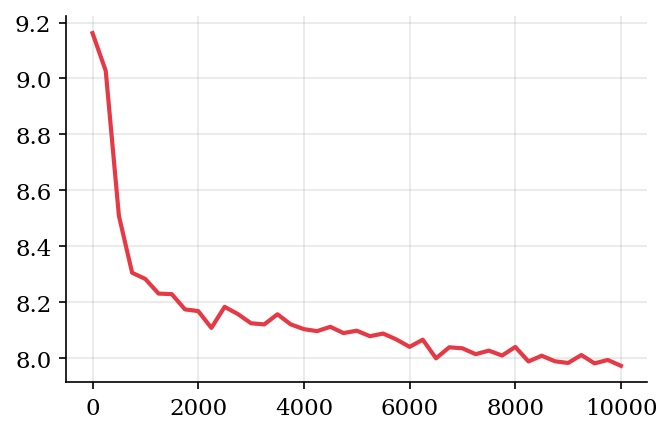

In [ ]:
# =============================================================================
# CELL 11: COMPREHENSIVE VISUALIZATION
# =============================================================================
fig = plt.figure(figsize=(18, 16))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

# Row 1: Learning curves and primary symplectic metric
ax1 = fig.add_subplot(gs[0, 0])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax1.plot(h['steps'], h['fluency_loss'], color=GAMMA_COLORS[gamma], label=f'γ={gamma}', linewidth=2)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Fluency Loss')
ax1.set_title('Fluency Task')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(gs[0, 1])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax2.plot(h['steps'], h['energy_ratio'], color=GAMMA_COLORS[gamma], label=f'γ={gamma}', linewidth=2)
ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Isometry (R=1)')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Energy Ratio R')
ax2.set_title('⭐ Energy Ratio (Leakage-Free)')
ax2.legend(loc='upper right')

ax3 = fig.add_subplot(gs[0, 2])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax3.plot(h['steps'], h['det_residual'], color=GAMMA_COLORS[gamma], label=f'γ={gamma}', linewidth=2)
ax3.set_xlabel('Training Steps')
ax3.set_ylabel('|det(J) - 1|')
ax3.set_title('Subspace det(J) (Trends Only)')
ax3.legend(loc='upper right')
ax3.set_yscale('log')

# Row 2: Condition number and symplectic norm
ax4 = fig.add_subplot(gs[1, 0])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax4.plot(h['steps'], h['condition_number'], color=GAMMA_COLORS[gamma], label=f'γ={gamma}', linewidth=2)
ax4.set_xlabel('Training Steps')
ax4.set_ylabel('Condition Number κ(J)')
ax4.set_title('Jacobian Conditioning')
ax4.legend(loc='upper right')
ax4.set_yscale('log')

ax5 = fig.add_subplot(gs[1, 1])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax5.plot(h['steps'], h['symplectic_norm'], color=GAMMA_COLORS[gamma], label=f'γ={gamma}', linewidth=2)
ax5.set_xlabel('Training Steps')
ax5.set_ylabel('||J^T Ω J - Ω||')
ax5.set_title('Symplectic Form Deviation')
ax5.legend(loc='upper right')

# Energy ratio vs loss trajectory
ax6 = fig.add_subplot(gs[1, 2])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    ax6.scatter(h['energy_ratio'], h['fluency_loss'], c=GAMMA_COLORS[gamma],
                label=f'γ={gamma}', alpha=0.7, s=30)
    ax6.plot(h['energy_ratio'], h['fluency_loss'], color=GAMMA_COLORS[gamma], alpha=0.3, linewidth=1)
ax6.axvline(x=1.0, color='black', linestyle='--', alpha=0.3)
ax6.set_xlabel('Energy Ratio R')
ax6.set_ylabel('Fluency Loss')
ax6.set_title('Learning Trajectory (R vs Loss)')
ax6.legend(loc='upper right')

# Row 3: Final comparisons
ax7 = fig.add_subplot(gs[2, 0])
gammas = list(GAMMA_VALUES)
final_R = [all_results[g]['final_energy_ratio'] for g in gammas]
colors = ['#2A9D8F' if r >= 1 else '#E63946' for r in final_R]
ax7.bar(range(len(gammas)), [r - 1 for r in final_R], color=colors)
ax7.axhline(y=0, color='black', linewidth=1)
ax7.set_xticks(range(len(gammas)))
ax7.set_xticklabels([str(g) for g in gammas])
ax7.set_xlabel('γ')
ax7.set_ylabel('R - 1')
ax7.set_title('Final Energy Ratio Deviation')

ax8 = fig.add_subplot(gs[2, 1])
final_det = [all_results[g]['final_det_residual'] for g in gammas]
final_symp = [all_results[g]['final_symplectic_norm'] for g in gammas]
x_pos = np.arange(len(gammas))
ax8.bar(x_pos - 0.2, final_det, width=0.4, color='#E63946', label='|det(J)-1|')
ax8.bar(x_pos + 0.2, final_symp, width=0.4, color='#2A9D8F', label='||J^TΩJ-Ω||')
ax8.set_xticks(x_pos)
ax8.set_xticklabels([str(g) for g in gammas])
ax8.set_xlabel('γ')
ax8.set_ylabel('Deviation')
ax8.set_title('Final Subspace Metrics')
ax8.legend()

# Learning speed vs energy ratio
ax9 = fig.add_subplot(gs[2, 2])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    fluency = np.array(h['fluency_loss'])
    R = np.array(h['energy_ratio'])
    if len(fluency) > 1:
        loss_deriv = -np.diff(fluency)
        R_mid = (R[:-1] + R[1:]) / 2
        ax9.scatter(R_mid, loss_deriv, c=GAMMA_COLORS[gamma], label=f'γ={gamma}', alpha=0.7, s=30)
ax9.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax9.axvline(x=1.0, color='black', linestyle='--', alpha=0.3)
ax9.set_xlabel('Energy Ratio R')
ax9.set_ylabel('Learning Rate (-ΔLoss)')
ax9.set_title('Learning Speed vs Volume Change')
ax9.legend(loc='upper right')

# Row 4: Phase transition detection
ax10 = fig.add_subplot(gs[3, :])
for gamma in GAMMA_VALUES:
    h = all_results[gamma]['history']
    steps = np.array(h['steps'])
    fluency = np.array(h['fluency_loss'])
    R = np.array(h['energy_ratio'])

    # Normalize for overlay
    fluency_norm = (fluency - fluency.min()) / (fluency.max() - fluency.min() + 1e-8)
    R_centered = R - 1.0  # Center at 0
    R_norm = R_centered / (np.abs(R_centered).max() + 1e-8) * 0.5 + 0.5  # Scale to [0, 1]

    ax10.plot(steps, fluency_norm, color=GAMMA_COLORS[gamma], linewidth=2,
              label=f'γ={gamma} loss' if gamma == 0.0 else '')
    ax10.plot(steps, R_norm, color=GAMMA_COLORS[gamma], linewidth=1, linestyle='--',
              label=f'γ={gamma} R' if gamma == 0.0 else '')

ax10.set_xlabel('Training Steps')
ax10.set_ylabel('Normalized Value')
ax10.set_title('Loss (solid) vs Energy Ratio (dashed) - Phase Transition Detection')
ax10.legend(['Loss (all γ)', 'R (all γ)'], loc='upper right')

plt.savefig(RESULTS_DIR / 'symplectic_analysis_v2.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'✅ Saved: {RESULTS_DIR}/symplectic_analysis_v2.png')

In [ ]:
# =============================================================================
# CELL 12: PHASE TRANSITION DETECTION
# =============================================================================
print('\n' + '=' * 70)
print('🔬 PHASE TRANSITION ANALYSIS')
print('=' * 70)

fig, axes = plt.subplots(len(GAMMA_VALUES), 1, figsize=(14, 3*len(GAMMA_VALUES)), sharex=True)
if len(GAMMA_VALUES) == 1:
    axes = [axes]

phase_transitions = {}

for idx, gamma in enumerate(GAMMA_VALUES):
    ax = axes[idx]
    h = all_results[gamma]['history']
    steps = np.array(h['steps'])
    fluency = np.array(h['fluency_loss'])
    R = np.array(h['energy_ratio'])

    # Normalize
    fluency_norm = (fluency - fluency.min()) / (fluency.max() - fluency.min() + 1e-8)
    R_norm = (R - R.min()) / (R.max() - R.min() + 1e-8)

    ax.plot(steps, fluency_norm, color='#2A9D8F', label='Fluency Loss', linewidth=2)
    ax.plot(steps, R_norm, color='#E63946', label='Energy Ratio R', linewidth=2)
    ax.fill_between(steps, 0, R_norm, color='#E63946', alpha=0.1)

    # Detect phase transition: steepest loss drop
    if len(fluency) > 3:
        loss_deriv = -np.diff(fluency)
        transition_idx = np.argmax(loss_deriv)
        transition_step = steps[transition_idx]
        R_at_transition = R[transition_idx]
        phase_transitions[gamma] = {
            'step': int(transition_step),
            'energy_ratio': float(R_at_transition),
            'loss_drop': float(loss_deriv[transition_idx])
        }
        ax.axvline(x=transition_step, color='purple', linestyle='--', alpha=0.7,
                   label=f'Phase transition @ {transition_step}')

    ax.set_ylabel(f'γ={gamma}')
    ax.legend(loc='upper right')
    ax.set_title(f'γ={gamma}: Loss & Energy Ratio (R={R[-1]:.3f} final)')

axes[-1].set_xlabel('Training Steps')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'phase_transitions_v2.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nPhase Transitions Detected:')
print(f'{"γ":>6} {"Step":>8} {"R":>10} {"ΔLoss":>10}')
print('-' * 40)
for g, pt in phase_transitions.items():
    print(f'{g:>6.1f} {pt["step"]:>8d} {pt["energy_ratio"]:>10.3f} {pt["loss_drop"]:>10.4f}')

print(f'\n✅ Saved: {RESULTS_DIR}/phase_transitions_v2.png')

In [ ]:
# =============================================================================
# CELL 13: SAVE RESULTS
# =============================================================================
summary = f"""EXPT-12e: GAMMA SWEEP WITH SYMPLECTIC TRACKING (v2)
{'='*65}

METHODOLOGY:
  1. Subspace Jacobian (dim×dim):
     - J_ij = (F(x + ε·e_j) - F(x))_i / ε
     - CAVEAT: Subject to subspace leakage
     - Interpret TRENDS and CROSS-γ DIFFERENCES, not absolute values

  2. Energy Ratio (leakage-free): ⭐
     - R = ||F(x + ε·v) - F(x)||_full / ε
     - Measures TOTAL displacement across ALL {train_cfg.jacobian_dim} dimensions
     - R > 1: Expansion, R < 1: Contraction, R = 1: Isometry

RESULTS:
{"γ":>6} {"Fluency":>10} {"det-1":>12} {"R":>10} {"κ":>10}
{'-'*50}
"""

for g in GAMMA_VALUES:
    r = all_results[g]
    summary += f"{g:>6.1f} {r['final_fluency_loss']:>10.4f} {r['final_det_residual']:>12.4f} {r['final_energy_ratio']:>10.3f} {r['final_condition_number']:>10.1f}\n"

summary += f"""
PHASE TRANSITIONS:
{"γ":>6} {"Step":>8} {"R at transition":>15}
{'-'*35}
"""
for g, pt in phase_transitions.items():
    summary += f"{g:>6.1f} {pt['step']:>8d} {pt['energy_ratio']:>15.3f}\n"

summary += f"""
INTERPRETATION GUIDE:
  - |det(J)-1| < 1 consistently: Likely subspace leakage, not true contraction
  - |det(J)-1| SPIKES then recovers: Phase transition signal
  - R ≠ 1: TRUE volume change (leakage-free measurement)
  - Cross-γ differences meaningful (same leakage affects all γ)

Total runtime: {total_time/3600:.1f} hours
"""

with open(RESULTS_DIR / 'summary.txt', 'w') as f:
    f.write(summary)

all_r = {}
for g, r in all_results.items():
    all_r[str(g)] = {k: v if k != 'history' else {hk: [float(x) if not np.isnan(x) else 0.0 for x in hv] for hk, hv in v.items()} for k, v in r.items()}

with open(RESULTS_DIR / 'all_results.json', 'w') as f:
    json.dump(all_r, f, indent=2)

with open(RESULTS_DIR / 'phase_transitions.json', 'w') as f:
    json.dump({str(k): v for k, v in phase_transitions.items()}, f, indent=2)

print(summary)
print(f'\n✅ All results saved to {RESULTS_DIR}/')